# DeepTICA: Alanine dipeptide from multithermal simulation

Reference paper: _Bonati, Piccini and Parrinello, [PNAS](https://www.pnas.org/doi/10.1073/pnas.2113533118) (2020)_ [[arXiv]](https://arxiv.org/abs/2107.03943).

Prerequisite: DeepTICA tutorial.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/example/ex_DeepTICA.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print('Done!')

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Alanine dipeptide: OPES Multithermal -> DeepTICA 

In this example we illustrate a case of applying DeepTDA to a biased simulation, taken from the [DeepTICA manuscript](https://www.pnas.org/doi/10.1073/pnas.2113533118). In particular, we will use the alanine dipeptide example in which we collect the simulations from the OPES multithermal simulation (which thus do not require to define a trial CV).

### Load data

First we load the COLVAR file(s) containing the weights of the OPES simulation and the input features, in this case they are the 45 interatomic distances between heavy atoms.

We discard the initial part of the simulation to put ourselves in the quasi-static regime, which is very quickly reached by OPES (it can be monitored by looking at the DELTAFS file for the multicanonical simulation).

The data is downloaded from the Github [repository](https://github.com/luigibonati/deep-learning-slow-modes) associated with the [manuscript](https://www.pnas.org/doi/10.1073/pnas.2113533118). 

In [2]:
import pandas as pd
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

# load colvar files containing weights of the OPES simulations as well as the driver with the input features
opes = load_dataframe('https://raw.githubusercontent.com/luigibonati/deep-learning-slow-modes/main/data/ala2-multi/1_opes_multi/COLVAR',
                      start=15000,stop=50000)
feat = load_dataframe('https://raw.githubusercontent.com/luigibonati/deep-learning-slow-modes/main/data/ala2-multi/2_training_cvs/COLVAR_DRIVER',
                          start=15000,stop=50000)

# concatenate them
df = pd.concat([opes, feat[[i for i in feat.columns if (i not in opes.columns)]]], axis=1)

df

,time,phi,psi,ene,opes.bias,walker,d1,d2,d3,d4,...,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
0,15000.0,-1.24937,0.540396,-53.9859,1.725970,0,0.1522,0.233868,0.244634,0.382245,...,0.258908,0.277790,0.379264,0.498986,0.1229,0.1335,0.246437,0.225420,0.283532,0.1449
1,15001.0,-1.50515,1.438650,43.3469,-30.144900,0,0.1522,0.235165,0.241863,0.375188,...,0.255153,0.295903,0.367831,0.502540,0.1229,0.1335,0.252509,0.223947,0.291499,0.1449
2,15002.0,-1.29419,1.730900,-18.3581,-0.562392,0,0.1522,0.244679,0.231301,0.370506,...,0.252451,0.285218,0.363133,0.486784,0.1229,0.1335,0.241549,0.226609,0.276819,0.1449
3,15003.0,-2.53166,2.657820,-23.8477,0.715870,0,0.1522,0.234523,0.246725,0.382103,...,0.250699,0.317424,0.312897,0.441096,0.1229,0.1335,0.246988,0.230302,0.292824,0.1449
4,15004.0,-2.15710,2.395360,11.5125,-14.231600,0,0.1522,0.234793,0.251158,0.383453,...,0.262807,0.326766,0.339187,0.479339,0.1229,0.1335,0.251390,0.224343,0.292820,0.1449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,49995.0,-1.19288,0.532025,-28.4388,1.276180,0,0.1522,0.232503,0.245793,0.382845,...,0.258933,0.285152,0.382687,0.493388,0.1229,0.1335,0.242527,0.216974,0.264171,0.1449
34996,49996.0,-1.31044,-0.023952,-33.1943,1.544550,0,0.1522,0.237438,0.245095,0.377144,...,0.246469,0.276428,0.354929,0.473255,0.1229,0.1335,0.249179,0.221805,0.281781,0.1449
34997,49997.0,-1.66419,2.736990,-32.5060,1.518380,0,0.1522,0.240949,0.244720,0.385074,...,0.253170,0.327638,0.315540,0.453209,0.1229,0.1335,0.240503,0.223382,0.272337,0.1449
34998,49998.0,-1.71317,2.573260,19.0074,-17.968700,0,0.1522,0.240229,0.247424,0.383137,...,0.245395,0.310855,0.318514,0.438564,0.1229,0.1335,0.243461,0.226024,0.279091,0.1449


In [3]:
# Select input features 
X = df.filter(regex='d').values
n_input = X.shape[1]

print(X.shape)

(35000, 45)


### Create time-lagged dataset

**Compute weights for time rescaling**

Here we extract the time $t$, the energy $E$ (needed for the multicanonical reweight [1]) and the bias $V$ from the COLVAR file. We then calculate the weights as:

\begin{cases}
    w = e^{\beta\ V + (\beta_0-\beta)\ E} & \text{if multicanonical}\\
    w = e^{\beta\ V}              & \text{otherwise}
\end{cases}

NB: note that if simulation temperature $\beta_0$ is equal to the reweighting one $\beta$ the multicanonical reweight coincides with the standard umbrella sampling-like case.

Once we have computed the weights, we rescale the time at step $k$ by using the instantaneus acceleration:

$$ dt'_k = w_k\ dt $$

and then compute the cumulative rescaled time:

$$ t'_k = \sum_{i=0} ^k dt'_i $$



[1] Invernizzi, Piaggi, and Parrinello. "Unified approach to enhanced sampling." _Physical Review X_ 10.4 (2020): 041034.


---

| Parameter | Type | Description |
| :- | :- | :- |
| multicanonical | bool | flag to determine if using a standard reweight (false) or a multicanonical one (true) |
| temp | float | reweighting temperature |
| temp0 | float | simulation temperature (only needed if multicanonical == True) |




In [4]:
#------------- PARAMETERS -------------
multicanonical    = True
temp              = 300.
temp0             = 300.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = df['time'].values # save time
ene = df['ene'].values.astype(np.float64) # store energy as long double
bias = df.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweights = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweights += (beta0-beta)*ene

In order to train the Deep-TICA CVs we will need to compute the time-lagged covariance matrices in the rescaled time $t'$. The standard way is to look for configurations which are distant a lag-time $\tau$ in the time series. However, in the rescaled time the time-series is _exponentially_ unevenly spaced. Hence, a naive search will lead to severe numerical issue. To address this, we use the algorithm proposed in [2]. In a nutshell, this method assume that the observable $O(t'_k)$ have the same value from scaled time $t'_k$ to $t'_{k+1}$. This leads to weighting each pair of configurations based both on the rescaled time around $t'_k$ and $t'_k+\tau$ (see supp. information of [2] for details). All of this is done under the hood in the function `find_time_lagged_configurations`. To generate the training set we use the function `create_time_lagged_dataset` which searches for the pairs of configurations and the corresponding weight.

[2] Yang and Parrinello. "Refining collective coordinates and improving free energy representation in variational enhanced sampling." _Journal of chemical theory and computation_ 14.6 (2018): 2889-2894.

---

| Parameter | Type | Description |
| :- | :- | :- |
| lag_time | float | lag_time for the calculation of the covariance matrices [in rescaled time] |
| n_train | int | number of training configurations |
| n_valid | int | number of validation configurations |


In [5]:
#------------- PARAMETERS -------------
lag_time = 1.
#--------------------------------------

# create dataset
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,progress_bar=True)

# create datamodule (split train valid)
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

datamodule

100%|██████████| 34997/34997 [00:08<00:00, 4223.97it/s]
/Users/luigi/work/mlcolvar/mlcolvar/utils/timelagged.py:169: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)


DictModule(dataset -> DictDataset( "data": [66163, 45], "data_lag": [66163, 45], "weights": [66163], "weights_lag": [66163] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=False),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=False))

### Define model

In [6]:
from mlcolvar.cvs import DeepTICA

n_components = 2
nn_layers = [n_input, 30, 30, n_components]
options= {'nn': {'activation': 'tanh'}}

model = DeepTICA(nn_layers, options=options)
model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): Tanh()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (tica): TICA(in_features=2, out_features=2)
)

### Define Trainer & Fit

In [7]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-3, patience=10)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | ?        | ?        
1 | norm_in | Normalization         | 0      | [45]     | [45]     
2 | nn      | FeedForward           | 2.4 K  | [45]     | [2]      
3 | tica    | TICA                  | 0      | [2]      | [2]      
-------------------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated 

[Warning] Normalization: the following features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]])
                                                                           

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 393: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s, v_num=1]


We can monitor how the individual eigenvalues are optimized during training.

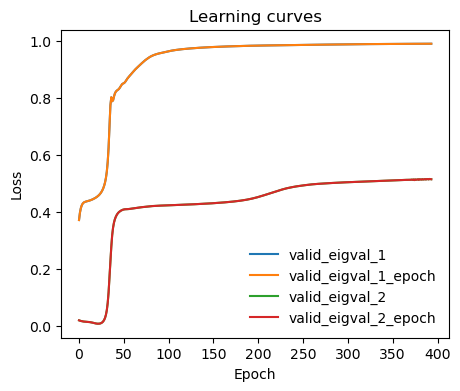

In [9]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Normalize output

For convenience, we standardize the CVs to be between -1 and 1.

In [ ]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.tools.utils import Statistics

#X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm

### Compute FES

We can plot the free energy profile along the selected CVs. First we compute it in the 2D space, from which we learn that the first TICA refers to the transition between two long-lived metastable states, while the second the faster transitions within the left basin.

Text(0.5, 0, 'Deep-TICA 2')

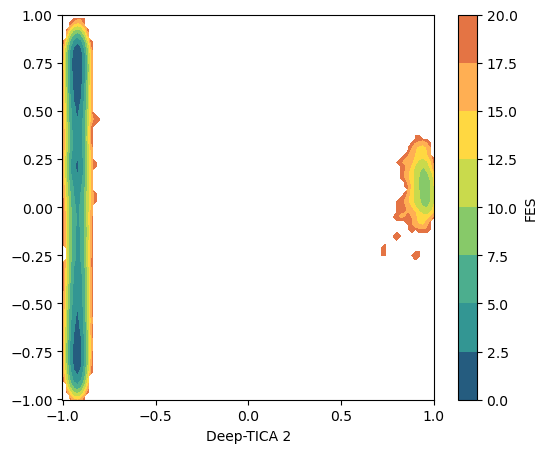

In [ ]:
from mlcolvar.utils.fes import compute_fes

fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

w = np.exp(logweights)
fes,grid,bounds,error = compute_fes(s,
                                    weights=w,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, ax = ax, eps=1e-10)

ax.set_xlabel('Deep-TICA 1')
ax.set_xlabel('Deep-TICA 2')

We can also plot the free energy profiles along each component. From the 2D FES above we understand that for the second CV we need to compute the FES only for the points in which the first CV is < 0, in order to describe the barrier between the faster states. 

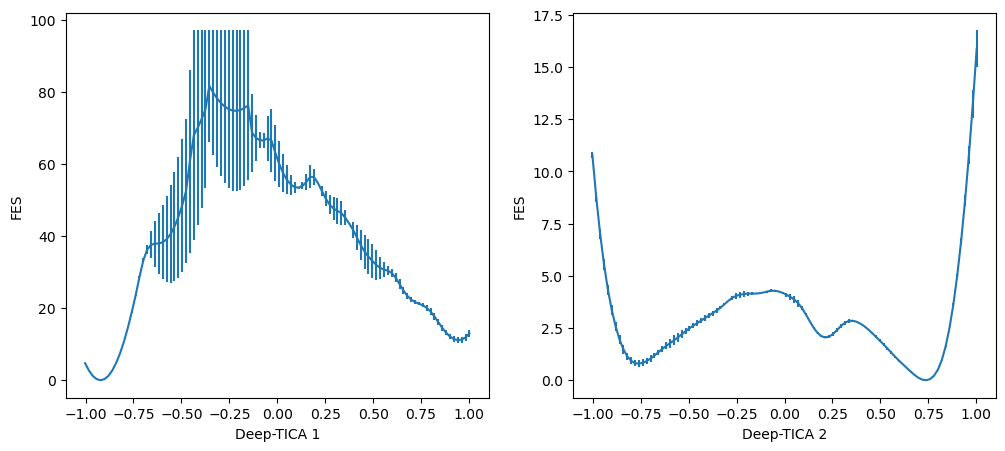

In [ ]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

for i in range(n_components):
    w = np.exp(logweights)

    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i] if i == 0 else s[s[:,0] < 0, i ], 
                                        weights=w if i == 0 else w[s[:,0] < 0 ],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

Note that the huge uncertainty on the free energy barrier is due to the lack of points between the states in the multithermal simulation.

### Plot CVs isolines in $\phi-\psi$ space

To understand to what states the CVs refer to, we can visualize them in the Ramachandran plot ($\phi$ and $\psi$).

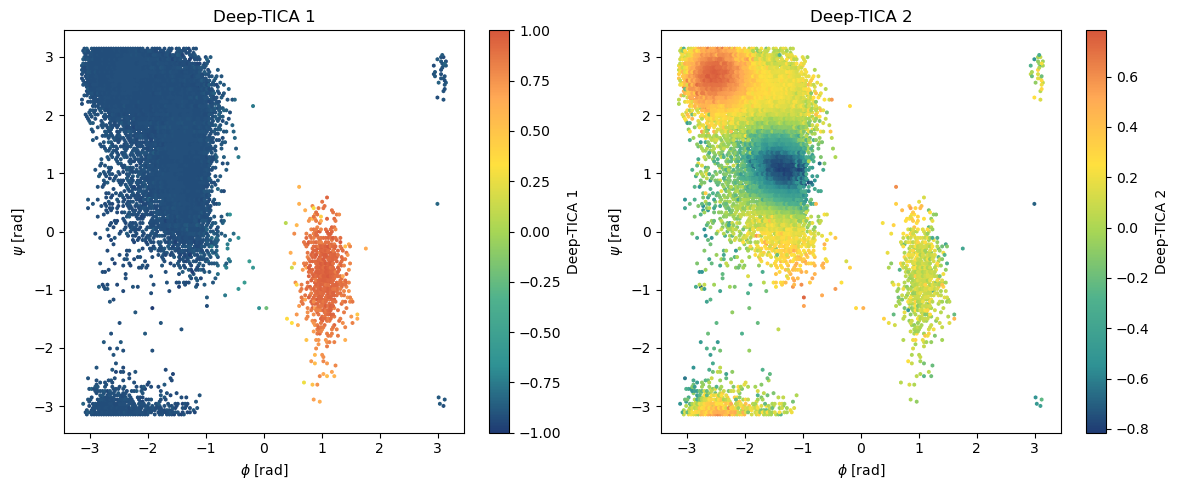

In [ ]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

x = df['phi'].values
y = df['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

You can try out also the other examples reported in the paper, such as applying DeepTICA to a simulation biasing a bad CV (the $\psi$ dihedral angle). 